In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import shutil

shutil.copyfile("/content/drive/MyDrive/dataset/dataset.rar", '/content/dataset.rar')

'/content/dataset.rar'

In [ ]:
!pip install unrar
!unrar x dataset.rar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from dataset.rar

Creating    dataset                                                   OK
Creating    dataset/test                                              OK
Creating    dataset/test/chatamari                                    OK
Extracting  dataset/test/chatamari/1.jpeg                                  0%  OK 
Extracting  dataset/test/chatamari/11.jpeg                                 0%  OK 
Extracting  dataset/test/chatamari/117.jpeg                                0%  OK 
Extracting  dataset/test/chatamari/125.jpeg                                0%  OK 
Extracting  dataset/test/chatamari/132.jpeg                                0%  OK 
Extracting  dataset/test/chatamari/146.jpeg                                0%  OK 
Extracting  dataset/test/chatama

In [ ]:
import tensorflow as tf

In [ ]:
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory="dataset/train/",
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory="dataset/test/",
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                shuffle=False)

Found 1548 files belonging to 9 classes.
Found 395 files belonging to 9 classes.


Baseline Model

In [ ]:
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(9, activation="softmax")                                     
])

baseline_model.compile(loss="categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

baseline_history = baseline_model.fit(train_data,
                                      epochs=5,
                                      validation_data=test_data)

Epoch 1/5
49/49 [==============================] - 35s 372ms/step - loss: 170.2897 - accuracy: 0.1447 - val_loss: 4.5284 - val_accuracy: 0.1747
Epoch 2/5
49/49 [==============================] - 14s 246ms/step - loss: 2.1879 - accuracy: 0.4057 - val_loss: 2.8214 - val_accuracy: 0.2684
Epoch 3/5
49/49 [==============================] - 12s 234ms/step - loss: 0.6940 - accuracy: 0.7791 - val_loss: 2.8486 - val_accuracy: 0.2962
Epoch 4/5
49/49 [==============================] - 14s 273ms/step - loss: 0.1489 - accuracy: 0.9780 - val_loss: 3.0136 - val_accuracy: 0.3266
Epoch 5/5
49/49 [==============================] - 16s 299ms/step - loss: 0.0431 - accuracy: 0.9961 - val_loss: 3.2280 - val_accuracy: 0.3241


There is huge issue of overfitting

Another model with augmentation layer and constraining pixel value between 0 to 1

In [ ]:
def normalize(image, label):
  return image/255., label

In [ ]:
train_data = train_data.map(normalize)
test_data = test_data.map(normalize)

In [ ]:
dat = train_data.take(1)
list(dat.as_numpy_iterator())

[(array([[[[8.52440894e-02, 7.85214081e-02, 3.88555415e-02],
           [9.98799503e-02, 8.63945633e-02, 9.15766358e-02],
           [1.92066848e-01, 1.52631074e-01, 7.36294612e-02],
           ...,
           [8.32002819e-01, 5.73179305e-01, 3.37885141e-01],
           [8.33173275e-01, 5.74349761e-01, 3.45958620e-01],
           [8.32633018e-01, 5.73809505e-01, 3.44477832e-01]],
  
          [[1.04651861e-01, 9.95698273e-02, 8.27631056e-02],
           [1.49259716e-01, 1.13745488e-01, 5.83833531e-02],
           [4.70708281e-01, 3.94197673e-01, 2.62434959e-01],
           ...,
           [8.19957912e-01, 5.58963478e-01, 3.05952311e-01],
           [8.13795507e-01, 5.52801073e-01, 2.99789906e-01],
           [8.10414135e-01, 5.48069179e-01, 3.02010864e-01]],
  
          [[1.22689083e-01, 8.33033323e-02, 4.66186553e-02],
           [4.18117255e-01, 3.42977226e-01, 2.12865159e-01],
           [6.24759912e-01, 5.01890779e-01, 3.38095248e-01],
           ...,
           [8.06302547e-01, 5

In [ ]:
# Make augmentation layer

augmentation_layer = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomCrop(200, 200)
], name="augmentation_layer")

In [ ]:
import matplotlib.pyplot as plt
import random

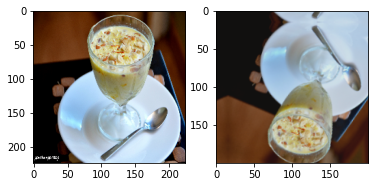

In [ ]:
image = list(dat.as_numpy_iterator())[0][0][random.randint(0, 31)]
augmented_image = augmentation_layer(image)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(augmented_image)

In [ ]:
from tensorflow.keras import layers, Model

In [ ]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
aug_layer = augmentation_layer(inputs)
conv_1 = layers.Conv2D(10, 3, activation="relu")(aug_layer)
conv_2 = layers.Conv2D(10, 3, activation="relu")(conv_1)
max_1 = layers.MaxPool2D(2)(conv_2)
conv_3 = layers.Conv2D(10, 3, activation="relu")(max_1)
conv_4 = layers.Conv2D(10, 3, activation="relu")(conv_3)
max_2 = layers.MaxPool2D(2)(conv_4)
flat_layer = layers.Flatten()(max_2)
outputs = layers.Dense(9, activation="softmax")(flat_layer)
model_1 = Model(inputs, outputs)

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (200, 200, 3)            0         
 ial)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 198, 198, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 196, 196, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 98, 98, 10)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 10)        910   

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [ ]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data,
                        validation_data=test_data,
                        epochs=5)

Epoch 1/5
49/49 [==============================] - 15s 238ms/step - loss: 2.2205 - accuracy: 0.2080 - val_loss: 2.0973 - val_accuracy: 0.2025
Epoch 2/5
49/49 [==============================] - 14s 262ms/step - loss: 1.9065 - accuracy: 0.2913 - val_loss: 1.8775 - val_accuracy: 0.3013
Epoch 3/5
49/49 [==============================] - 13s 234ms/step - loss: 1.7565 - accuracy: 0.3450 - val_loss: 1.7647 - val_accuracy: 0.3241
Epoch 4/5
49/49 [==============================] - 12s 232ms/step - loss: 1.7081 - accuracy: 0.3702 - val_loss: 1.7759 - val_accuracy: 0.3392
Epoch 5/5
49/49 [==============================] - 13s 245ms/step - loss: 1.6858 - accuracy: 0.3650 - val_loss: 1.7294 - val_accuracy: 0.3494


In [ ]:
model_1.evaluate(test_data)

13/13 [==============================] - 2s 180ms/step - loss: 1.7294 - accuracy: 0.3494


[1.7294341325759888, 0.34936708211898804]

In [ ]:
test_dat = train_data.take(1)
test_dat = list(test_dat.as_numpy_iterator())

In [ ]:
def predict_and_plot():

  image = test_dat[0][0][random.randint(0, 31)]
  print(type(image))
  
  model_1.predict(tf.expand_dims(image, 0))
  plt.imshow(image)

In [ ]:
pred_probs = model_1.predict(test_data, verbose=1)

13/13 [==============================] - 3s 178ms/step


In [ ]:
pred_probs.shape

(395, 9)

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes

array([2, 8, 6, 5, 8, 8, 2, 5, 2, 7, 2, 5, 8, 8, 2, 6, 2, 5, 5, 0, 6, 0,
       5, 2, 5, 5, 5, 8, 5, 5, 2, 8, 8, 1, 5, 5, 8, 8, 6, 1, 6, 1, 7, 8,
       1, 8, 8, 7, 1, 6, 6, 6, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 8, 7, 0, 1,
       6, 6, 0, 6, 2, 8, 7, 2, 5, 2, 6, 2, 2, 2, 5, 6, 0, 2, 2, 6, 2, 6,
       6, 2, 7, 2, 5, 2, 2, 3, 2, 2, 2, 2, 8, 2, 5, 8, 5, 2, 2, 6, 2, 2,
       2, 5, 2, 2, 6, 2, 2, 6, 8, 2, 2, 2, 1, 2, 1, 2, 6, 1, 0, 8, 2, 1,
       8, 2, 8, 8, 8, 8, 8, 2, 2, 8, 2, 2, 6, 2, 8, 2, 8, 1, 1, 1, 6, 1,
       7, 8, 1, 8, 1, 8, 2, 8, 8, 8, 3, 8, 5, 5, 5, 5, 2, 5, 5, 2, 5, 5,
       5, 2, 2, 5, 5, 5, 2, 2, 2, 5, 5, 5, 5, 2, 2, 5, 2, 5, 5, 5, 6, 2,
       2, 2, 5, 5, 6, 5, 2, 7, 5, 2, 2, 2, 5, 5, 5, 2, 5, 5, 2, 2, 5, 5,
       5, 8, 2, 5, 5, 5, 2, 5, 5, 5, 5, 6, 5, 5, 5, 2, 5, 2, 5, 5, 6, 5,
       5, 2, 2, 2, 8, 5, 5, 5, 2, 5, 5, 6, 5, 5, 2, 6, 1, 5, 5, 5, 2, 2,
       5, 5, 6, 6, 6, 0, 6, 2, 5, 5, 2, 5, 5, 5, 6, 7, 6, 5, 6, 2, 0, 5,
       2, 5, 6, 5, 5, 8, 5, 5, 8, 2, 2, 5, 8, 5, 5,

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.3493670886075949

In [ ]:
import os

In [ ]:
labels = sorted(os.listdir('dataset/train'))
labels

['chatamari',
 'chhoila',
 'dalbhat',
 'dhindo',
 'gundruk',
 'kheer',
 'momo',
 'sekuwa',
 'selroti']

In [ ]:
report = classification_report(y_labels, pred_classes, target_names=labels)
print(report)

              precision    recall  f1-score   support

   chatamari       0.22      0.06      0.09        36
     chhoila       0.28      0.37      0.32        30
     dalbhat       0.29      0.51      0.37        53
      dhindo       0.00      0.00      0.00        27
     gundruk       0.00      0.00      0.00        20
       kheer       0.44      0.60      0.51        73
        momo       0.29      0.17      0.22        69
      sekuwa       0.33      0.15      0.20        34
     selroti       0.39      0.70      0.50        53

    accuracy                           0.35       395
   macro avg       0.25      0.28      0.25       395
weighted avg       0.29      0.35      0.30       395



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True, target_names=labels)
classification_report_dict

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.3493670886075949,
 'chatamari': {'f1-score': 0.08888888888888888,
  'precision': 0.2222222222222222,
  'recall': 0.05555555555555555,
  'support': 36},
 'chhoila': {'f1-score': 0.31884057971014496,
  'precision': 0.28205128205128205,
  'recall': 0.36666666666666664,
  'support': 30},
 'dalbhat': {'f1-score': 0.36986301369863017,
  'precision': 0.2903225806451613,
  'recall': 0.5094339622641509,
  'support': 53},
 'dhindo': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 27},
 'gundruk': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 20},
 'kheer': {'f1-score': 0.5057471264367815,
  'precision': 0.43564356435643564,
  'recall': 0.6027397260273972,
  'support': 73},
 'macro avg': {'f1-score': 0.2450670066188139,
  'precision': 0.24952551040535878,
  'recall': 0.2837201094520681,
  'support': 395},
 'momo': {'f1-score': 0.21818181818181817,
  'precision': 0.2926829268292683,
  'recall': 0.17391304347826086,
  'support': 69},
 'sekuwa': {'f1-scor

In [ ]:
import pandas as pd

report_df = pd.DataFrame(classification_report_dict).T

In [ ]:
report_df

,precision,recall,f1-score,support
chatamari,0.222222,0.055556,0.088889,36.000000
chhoila,0.282051,0.366667,0.318841,30.000000
dalbhat,0.290323,0.509434,0.369863,53.000000
dhindo,0.000000,0.000000,0.000000,27.000000
gundruk,0.000000,0.000000,0.000000,20.000000
kheer,0.435644,0.602740,0.505747,73.000000
momo,0.292683,0.173913,0.218182,69.000000
sekuwa,0.333333,0.147059,0.204082,34.000000
selroti,0.389474,0.698113,0.500000,53.000000
accuracy,0.349367,0.349367,0.349367,0.349367


<BarContainer object of 12 artists>

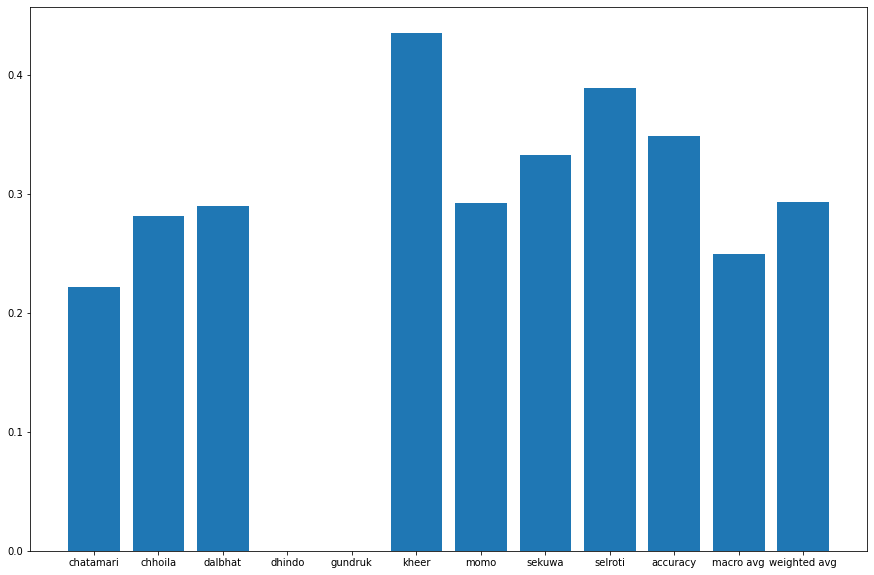

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(report_df.index, report_df["precision"].values)

In [ ]:
# Now trying another model without any built in augmentation layer

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_gen = ImageDataGenerator(rescale=1/255.,
                              rotation_range=20,
                              shear_range=0.2,
                              zoom_range=0.2,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_data = train_gen.flow_from_directory("dataset/train/",
                                           target_size=IMG_SIZE)

test_data = test_gen.flow_from_directory("dataset/test/",
                     target_size=IMG_SIZE,
                     shuffle=True)

Found 1548 images belonging to 9 classes.
Found 395 images belonging to 9 classes.


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (200, 200, 3)            0         
 ial)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 198, 198, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 196, 196, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 98, 98, 10)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 10)        910   

In [ ]:
# Now modeling new model without built in augmentation layer

input = layers.Input(shape=(224, 224, 3), name="input_layer")
conv_1 = layers.Conv2D(10, 3, activation="relu")(input)
conv_2 = layers.Conv2D(10, 3, activation="relu")(conv_1)
max_1 = layers.MaxPool2D(2)(conv_2)
conv_3 = layers.Conv2D(10, 3, activation="relu")(max_1)
conv_4 = layers.Conv2D(10, 3, activation="relu")(conv_3)
max_2 = layers.MaxPool2D(2)(conv_4)
flat_layer = layers.Flatten()(max_2)
output = layers.Dense(9, activation="softmax")(flat_layer)
model_2 = Model(input, output)

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data,
              epochs=5,
              validation_data=test_data)

Epoch 1/5
49/49 [==============================] - 63s 1s/step - loss: 1.9755 - accuracy: 0.2707 - val_loss: 1.8502 - val_accuracy: 0.2886
Epoch 2/5
49/49 [==============================] - 67s 1s/step - loss: 1.8469 - accuracy: 0.3185 - val_loss: 1.7821 - val_accuracy: 0.3494
Epoch 3/5
49/49 [==============================] - 53s 1s/step - loss: 1.7621 - accuracy: 0.3598 - val_loss: 1.7303 - val_accuracy: 0.3823
Epoch 4/5
49/49 [==============================] - 52s 1s/step - loss: 1.6830 - accuracy: 0.3960 - val_loss: 1.7863 - val_accuracy: 0.3671
Epoch 5/5
49/49 [==============================] - 50s 1s/step - loss: 1.6667 - accuracy: 0.3876 - val_loss: 1.6680 - val_accuracy: 0.3899


In [ ]:
# Trying bigger model

In [ ]:
input = layers.Input(shape=(224, 224, 3), name="input_layer")

conv_1 = layers.Conv2D(10, 3, activation="relu")(input)
conv_2 = layers.Conv2D(10, 3, activation="relu")(conv_1)
max_1 = layers.MaxPool2D(2)(conv_2)

conv_3 = layers.Conv2D(10, 3, activation="relu")(max_1)
conv_4 = layers.Conv2D(10, 3, activation="relu")(conv_3)
max_2 = layers.MaxPool2D(2)(conv_4)

conv_5 = layers.Conv2D(10, 3, activation="relu")(max_2)
conv_6 = layers.Conv2D(10, 3, activation="relu")(conv_5)
max_3 = layers.MaxPool2D(2)(conv_6)

flat_layer = layers.Flatten()(max_3)
output = layers.Dense(9, activation="softmax")(flat_layer)
model_3 = Model(input, output)

In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(train_data,
              epochs=5,
              validation_data=test_data)

Epoch 1/5
49/49 [==============================] - 52s 1s/step - loss: 2.0813 - accuracy: 0.2183 - val_loss: 1.9811 - val_accuracy: 0.2835
Epoch 2/5
49/49 [==============================] - 52s 1s/step - loss: 1.8883 - accuracy: 0.3017 - val_loss: 1.8412 - val_accuracy: 0.3114
Epoch 3/5
49/49 [==============================] - 50s 1s/step - loss: 1.8487 - accuracy: 0.3030 - val_loss: 1.7784 - val_accuracy: 0.3418
Epoch 4/5
49/49 [==============================] - 50s 1s/step - loss: 1.8135 - accuracy: 0.3262 - val_loss: 1.7655 - val_accuracy: 0.3468
Epoch 5/5
49/49 [==============================] - 50s 1s/step - loss: 1.8104 - accuracy: 0.3185 - val_loss: 1.7967 - val_accuracy: 0.3696


In [ ]:
# Applying transfer learning concepts

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
avg_pooling = layers.GlobalAveragePooling2D()(base_layer)
outputs = layers.Dense(9, activation="softmax")(avg_pooling)
model_4 = Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 9)                 11529     
                                                                 
Total params: 4,061,100
Trainable params: 11,529
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_4 = model_4.fit(train_data,
              epochs=5,
              validation_data=test_data)

Epoch 1/5
49/49 [==============================] - 63s 1s/step - loss: 2.1360 - accuracy: 0.1764 - val_loss: 2.1350 - val_accuracy: 0.1342
Epoch 2/5
49/49 [==============================] - 51s 1s/step - loss: 2.1342 - accuracy: 0.1757 - val_loss: 2.1232 - val_accuracy: 0.1848
Epoch 3/5
49/49 [==============================] - 58s 1s/step - loss: 2.1295 - accuracy: 0.1544 - val_loss: 2.1257 - val_accuracy: 0.1747
Epoch 4/5
49/49 [==============================] - 62s 1s/step - loss: 2.1295 - accuracy: 0.1899 - val_loss: 2.1204 - val_accuracy: 0.1747
Epoch 5/5
49/49 [==============================] - 52s 1s/step - loss: 2.1313 - accuracy: 0.1757 - val_loss: 2.1175 - val_accuracy: 0.1747


In [ ]:
# Probably due to normalization and augmentation

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory="dataset/train/",
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory="dataset/test/",
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                shuffle=False)

Found 1548 files belonging to 9 classes.
Found 395 files belonging to 9 classes.


In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
avg_pooling = layers.GlobalAveragePooling2D()(base_layer)
outputs = layers.Dense(9, activation="softmax")(avg_pooling)
model_5 = Model(inputs, outputs)

In [ ]:
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_5 = model_5.fit(train_data,
              epochs=5,
              validation_data=test_data)

Epoch 1/5
49/49 [==============================] - 19s 266ms/step - loss: 1.3603 - accuracy: 0.5911 - val_loss: 0.7648 - val_accuracy: 0.8253
Epoch 2/5
49/49 [==============================] - 13s 239ms/step - loss: 0.6452 - accuracy: 0.8488 - val_loss: 0.5310 - val_accuracy: 0.8557
Epoch 3/5
49/49 [==============================] - 13s 242ms/step - loss: 0.4651 - accuracy: 0.8882 - val_loss: 0.4390 - val_accuracy: 0.8835
Epoch 4/5
49/49 [==============================] - 13s 239ms/step - loss: 0.3823 - accuracy: 0.9063 - val_loss: 0.3921 - val_accuracy: 0.8810
Epoch 5/5
49/49 [==============================] - 13s 238ms/step - loss: 0.3243 - accuracy: 0.9218 - val_loss: 0.3575 - val_accuracy: 0.9063


In [ ]:
model_5.evaluate(test_data)

13/13 [==============================] - 3s 198ms/step - loss: 0.3575 - accuracy: 0.9063


[0.3574851155281067, 0.9063290953636169]

In [ ]:
pred_prob = model_5.predict(test_data)
pred_prob

array([[9.2308265e-01, 4.8835329e-03, 4.4254735e-03, ..., 3.0255704e-03,
        1.0638358e-03, 1.4668928e-03],
       [2.2727658e-01, 1.7534481e-02, 1.2944549e-01, ..., 1.1385106e-02,
        3.9125469e-02, 2.6446264e-02],
       [6.2247813e-01, 1.8970132e-02, 1.5942149e-02, ..., 1.7955412e-01,
        9.2573844e-02, 1.2301639e-02],
       ...,
       [2.3904006e-04, 3.5639462e-04, 1.9813988e-05, ..., 1.3986534e-03,
        5.2488176e-04, 9.9649686e-01],
       [1.9409337e-04, 1.3700924e-05, 8.7825674e-06, ..., 1.5821956e-03,
        4.1648342e-05, 9.9809104e-01],
       [1.5962255e-04, 8.0302090e-04, 4.1994765e-05, ..., 9.5142294e-03,
        1.1075861e-02, 9.7733736e-01]], dtype=float32)

In [ ]:
pred_class = tf.argmax(pred_prob, axis=1)
pred_class

<tf.Tensor: shape=(395,), dtype=int64, numpy=
array([0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 1, 1, 1, 1, 1, 7, 1, 1,
       1, 1, 1, 7, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 7, 1, 1, 7, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2,
       2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 0, 3, 3, 3, 2, 3, 3, 2, 3, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 1, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5,
       5, 5, 2, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
     

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
score_5 = accuracy_score(y_labels, pred_class)
score_5

0.9063291139240506

In [ ]:
labels = sorted(os.listdir('dataset/train'))
labels

['chatamari',
 'chhoila',
 'dalbhat',
 'dhindo',
 'gundruk',
 'kheer',
 'momo',
 'sekuwa',
 'selroti']

In [ ]:
report_5 = classification_report(y_labels, pred_class, target_names=labels)
print(report_5)

              precision    recall  f1-score   support

   chatamari       0.89      0.92      0.90        36
     chhoila       0.86      0.80      0.83        30
     dalbhat       0.79      0.94      0.86        53
      dhindo       0.84      0.59      0.70        27
     gundruk       0.94      0.85      0.89        20
       kheer       0.94      0.93      0.94        73
        momo       0.97      0.99      0.98        69
      sekuwa       0.83      0.85      0.84        34
     selroti       1.00      1.00      1.00        53

    accuracy                           0.91       395
   macro avg       0.90      0.87      0.88       395
weighted avg       0.91      0.91      0.90       395



In [ ]:
# Trying transfer learning with fine tuning top 5 layers

In [ ]:
base_model_2 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_2.trainable = True

for layer in base_model_2.layers[:-10]:
  layer.trainable = False

In [ ]:
for layer_number, layer in enumerate(base_model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model_2(inputs)
avg_pooling = layers.GlobalAveragePooling2D()(base_layer)
outputs = layers.Dense(9, activation="softmax")(avg_pooling)
model_6 = Model(inputs, outputs)

In [ ]:
model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

history_6 = model_6.fit(train_data,
              epochs=5,
              validation_data=test_data)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


49/49 [==============================] - 22s 270ms/step - loss: 1.6255 - accuracy: 0.5368 - val_loss: 1.0186 - val_accuracy: 0.7165
Epoch 2/5
49/49 [==============================] - 14s 255ms/step - loss: 0.8575 - accuracy: 0.8004 - val_loss: 0.5955 - val_accuracy: 0.8304
Epoch 3/5
49/49 [==============================] - 13s 245ms/step - loss: 0.5786 - accuracy: 0.8656 - val_loss: 0.4399 - val_accuracy: 0.8835
Epoch 4/5
49/49 [==============================] - 13s 244ms/step - loss: 0.4392 - accuracy: 0.8882 - val_loss: 0.3698 - val_accuracy: 0.9038
Epoch 5/5
49/49 [==============================] - 13s 242ms/step - loss: 0.3562 - accuracy: 0.9102 - val_loss: 0.3330 - val_accuracy: 0.9063


In [ ]:
# Fine tuning only 5 top layers
base_model_3 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_3.trainable = True

for layer in base_model_3.layers[:-5]:
  layer.trainable = False

In [ ]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model_3(inputs)
avg_pooling = layers.GlobalAveragePooling2D()(base_layer)
outputs = layers.Dense(9, activation="softmax")(avg_pooling)
model_7 = Model(inputs, outputs)

In [ ]:
model_7.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

history_7 = model_7.fit(train_data,
              epochs=5,
              validation_data=test_data)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


49/49 [==============================] - 22s 272ms/step - loss: 1.6945 - accuracy: 0.4793 - val_loss: 1.0801 - val_accuracy: 0.7620
Epoch 2/5
49/49 [==============================] - 13s 246ms/step - loss: 0.8996 - accuracy: 0.8172 - val_loss: 0.6523 - val_accuracy: 0.8253
Epoch 3/5
49/49 [==============================] - 14s 269ms/step - loss: 0.6017 - accuracy: 0.8721 - val_loss: 0.4820 - val_accuracy: 0.8759
Epoch 4/5
49/49 [==============================] - 13s 245ms/step - loss: 0.4738 - accuracy: 0.8947 - val_loss: 0.4016 - val_accuracy: 0.8835
Epoch 5/5
49/49 [==============================] - 13s 250ms/step - loss: 0.3922 - accuracy: 0.9199 - val_loss: 0.3593 - val_accuracy: 0.8987


In [ ]:
# Now increasing learning rate
base_model_4 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_4.trainable = True

for layer in base_model_4.layers[:-10]:
  layer.trainable = False

In [ ]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model_4(inputs)
avg_pooling = layers.GlobalAveragePooling2D()(base_layer)
outputs = layers.Dense(9, activation="softmax")(avg_pooling)
model_8 = Model(inputs, outputs)

In [ ]:
model_8.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_8 = model_8.fit(train_data,
              epochs=5,
              validation_data=test_data)

Epoch 1/5
49/49 [==============================] - 22s 272ms/step - loss: 0.6386 - accuracy: 0.7991 - val_loss: 0.3112 - val_accuracy: 0.8835
Epoch 2/5
49/49 [==============================] - 13s 246ms/step - loss: 0.1692 - accuracy: 0.9516 - val_loss: 0.2568 - val_accuracy: 0.9190
Epoch 3/5
49/49 [==============================] - 13s 245ms/step - loss: 0.0784 - accuracy: 0.9832 - val_loss: 0.2401 - val_accuracy: 0.9367
Epoch 4/5
49/49 [==============================] - 13s 243ms/step - loss: 0.0475 - accuracy: 0.9916 - val_loss: 0.2507 - val_accuracy: 0.9266
Epoch 5/5
49/49 [==============================] - 13s 245ms/step - loss: 0.0312 - accuracy: 0.9948 - val_loss: 0.2145 - val_accuracy: 0.9443


In [ ]:
# Satisfied with result, using augmented data for training to reduce overfiting

In [ ]:
train_gen = ImageDataGenerator(rotation_range=20,
                              shear_range=0.2,
                              zoom_range=0.2,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              horizontal_flip=True)

test_gen = ImageDataGenerator()

In [ ]:
train_data = train_gen.flow_from_directory("dataset/train/",
                                           target_size=IMG_SIZE)

test_data = test_gen.flow_from_directory("dataset/test/",
                     target_size=IMG_SIZE,
                     shuffle=True)

Found 1548 images belonging to 9 classes.
Found 395 images belonging to 9 classes.


In [ ]:
# Now increasing learning rate
base_model_5 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_5.trainable = True

for layer in base_model_5.layers[:-10]:
  layer.trainable = False

In [ ]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model_5(inputs)
avg_pooling = layers.GlobalAveragePooling2D()(base_layer)
outputs = layers.Dense(9, activation="softmax")(avg_pooling)
model_9 = Model(inputs, outputs)

In [ ]:
model_9.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_9 = model_9.fit(train_data,
              epochs=5,
              validation_data=test_data)

Epoch 1/5
49/49 [==============================] - 53s 981ms/step - loss: 0.6498 - accuracy: 0.7868 - val_loss: 0.3233 - val_accuracy: 0.8987
Epoch 2/5
49/49 [==============================] - 48s 970ms/step - loss: 0.2292 - accuracy: 0.9244 - val_loss: 0.3012 - val_accuracy: 0.9215
Epoch 3/5
49/49 [==============================] - 52s 1s/step - loss: 0.1457 - accuracy: 0.9541 - val_loss: 0.2552 - val_accuracy: 0.9367
Epoch 4/5
49/49 [==============================] - 53s 1s/step - loss: 0.1056 - accuracy: 0.9638 - val_loss: 0.2631 - val_accuracy: 0.9367
Epoch 5/5
49/49 [==============================] - 46s 942ms/step - loss: 0.0694 - accuracy: 0.9806 - val_loss: 0.4030 - val_accuracy: 0.9165


In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory="dataset/test/",
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                shuffle=False)

Found 395 files belonging to 9 classes.


In [ ]:
model_8.evaluate(test_data)

13/13 [==============================] - 4s 292ms/step - loss: 0.2592 - accuracy: 0.9139


[0.25916796922683716, 0.9139240384101868]

In [ ]:
model_9.evaluate(test_data)

13/13 [==============================] - 6s 272ms/step - loss: 0.2668 - accuracy: 0.9266


[0.26681676506996155, 0.9265822768211365]

In [ ]:
# Fine tuning 20 layers

In [ ]:
base_model_6 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_6.trainable = True

for layer in base_model_6.layers[:-20]:
  layer.trainable = False

In [ ]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model_6(inputs)
avg_pooling = layers.GlobalAveragePooling2D()(base_layer)
outputs = layers.Dense(9, activation="softmax")(avg_pooling)
model_10 = Model(inputs, outputs)

In [ ]:
model_10.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_10 = model_10.fit(train_data,
              epochs=5,
              validation_data=test_data)

Epoch 1/5
49/49 [==============================] - 61s 1s/step - loss: 0.7231 - accuracy: 0.7655 - val_loss: 0.2972 - val_accuracy: 0.9165
Epoch 2/5
49/49 [==============================] - 48s 995ms/step - loss: 0.2230 - accuracy: 0.9296 - val_loss: 0.2439 - val_accuracy: 0.9063
Epoch 3/5
49/49 [==============================] - 48s 980ms/step - loss: 0.1723 - accuracy: 0.9483 - val_loss: 0.2957 - val_accuracy: 0.9038
Epoch 4/5
49/49 [==============================] - 46s 943ms/step - loss: 0.1055 - accuracy: 0.9683 - val_loss: 0.2896 - val_accuracy: 0.9215
Epoch 5/5
49/49 [==============================] - 46s 929ms/step - loss: 0.0857 - accuracy: 0.9703 - val_loss: 0.2366 - val_accuracy: 0.9316


In [ ]:
model_10.evaluate(test_data)

13/13 [==============================] - 3s 193ms/step - loss: 0.2366 - accuracy: 0.9316


[0.23663204908370972, 0.9316455721855164]

In [ ]:
model_9.evaluate(test_data)

13/13 [==============================] - 3s 193ms/step - loss: 0.4030 - accuracy: 0.9165


[0.4029889702796936, 0.9164556860923767]

In [ ]:
model_10.save('/content/drive/MyDrive/nepalvision/nepalfoodvision')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/nepalvision/nepalfoodvision/assets


In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/nepalvision/nepalfoodvision')

In [ ]:
loaded_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_10  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 9)                 11529     
                                                                 
Total params: 4,061,100
Trainable params: 1,362,489
Non-trainable params: 2,698,611
_________________________________________________________________


In [ ]:
loaded_model.evaluate(test_data)

13/13 [==============================] - 7s 326ms/step - loss: 0.2366 - accuracy: 0.9316


[0.23663204908370972, 0.9316455721855164]